In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS


# Load the M4 dataset
m4 = M4.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m4\\', group='Monthly')[0]

m4['ds'] = pd.to_datetime(m4['ds']).astype(int)


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-03 19:16:32,324	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-03 19:16:32,577	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 24

In [4]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except KeyError as exc:
        raise KeyError(
            f"Forecast column '{forecast_col}' not found in predictions!") from exc
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

In [17]:
import numpy as np
import pandas as pd

# Make sure unique_ids are available
unique_ids = m4['unique_id'].unique()
data_sizes = [0.0025, 0.005, 0.008, 0.01, 0.02]
results = []

np.random.seed(42)  # For reproducibility

for size in data_sizes:

    n_ids = int(len(unique_ids) * size)
    print(f"\nTraining on {int(size * 100)}% of series, {n_ids} unique IDs")

    # Sample unique_ids for this data size
    selected_ids = np.random.choice(unique_ids, size=n_ids, replace=False)

    # Filter dataset for selected IDs
    m4_partial = m4[m4['unique_id'].isin(selected_ids)].copy()

    # Train/test split per series
    y_train_partial, y_test_partial = train_test_split(m4_partial, horizon)

    # Initialize forecast models
    nf = NeuralForecast(
        models=[
            NBEATS(
                input_size=input_size, 
                h=horizon,
                mlp_units=3 * [[32, 32]],
                n_blocks=[9,9],
                stack_types=['trend', 'seasonality'],
                early_stop_patience_steps=10,
                shared_weights= True,
            ),
            NBeatsStackMoe(
                input_size=input_size, 
                h=horizon,
                mlp_units=3 * [[32, 32]],
                n_blocks=[9,9],
                stack_types=['trend', 'seasonality'],
                early_stop_patience_steps=10,
                shared_weights= True,
            )
        ], 
        freq=1
    )

    # Train
    nf.fit(df=y_train_partial, val_size=horizon)

    # Predict
    predictions = nf.predict(futr_df=y_test_partial)

    # Evaluate
    smape_nbeats = calculate_smape(y_test_partial, predictions, 'NBEATS')
    smape_moe = calculate_smape(y_test_partial, predictions, 'NBeatsStackMoe')

    print(f"sMAPE - NBEATS: {smape_nbeats}, NBeatsStackMoe: {smape_moe}")

    results.append({
        'data_size': size,
        'sMAPE_NBEATS': smape_nbeats,
        'sMAPE_MOE': smape_moe,
    })



Training on 0% of series, 120 unique IDs


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
-------------------------------------------------------
10.4 K    Trainable params
1.6 K     Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
22        Modules in train mod

Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 12.41it/s, v_num=1745, train_loss_step=399.0, train_loss_epoch=356.0, valid_loss=487.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s, v_num=1745, train_loss_step=399.0, train_loss_epoch=356.0, valid_loss=487.0]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
4 | gate         | Sequential    | 498    | train
-------------------------------------------------------
10.9 K    Trainable params
1.6 K     Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s, v_num=1746, train_loss_step=402.0, train_loss_epoch=356.0, valid_loss=492.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s, v_num=1746, train_loss_step=402.0, train_loss_epoch=356.0, valid_loss=492.0]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 58.14it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.86it/s]
sMAPE - NBEATS: 0.1537263133445969, NBeatsStackMoe: 0.15726887598708117

Training on 0% of series, 240 unique IDs


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
-------------------------------------------------------
10.4 K    Trainable params
1.6 K     Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
22        Modules in train mod

Epoch 124: 100%|██████████| 8/8 [00:00<00:00, 13.62it/s, v_num=1749, train_loss_step=212.0, train_loss_epoch=390.0, valid_loss=522.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 124: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s, v_num=1749, train_loss_step=212.0, train_loss_epoch=390.0, valid_loss=522.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
4 | gate         | Sequential    | 498    | train
-------------------------------------------------------
10.9 K    Trainable params
1.6 K     Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 124: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s, v_num=1750, train_loss_step=214.0, train_loss_epoch=390.0, valid_loss=526.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 124: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s, v_num=1750, train_loss_step=214.0, train_loss_epoch=390.0, valid_loss=526.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.57it/s] 

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 59.21it/s]
sMAPE - NBEATS: 0.12739185007638354, NBeatsStackMoe: 0.1239000901237261

Training on 0% of series, 384 unique IDs


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
-------------------------------------------------------
10.4 K    Trainable params
1.6 K     Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
22        Modules in train mod

Epoch 83:  33%|███▎      | 4/12 [00:00<00:00,  8.53it/s, v_num=1753, train_loss_step=424.0, train_loss_epoch=447.0, valid_loss=528.0] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 83:  33%|███▎      | 4/12 [00:00<00:00,  8.48it/s, v_num=1753, train_loss_step=424.0, train_loss_epoch=447.0, valid_loss=528.0]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
4 | gate         | Sequential    | 498    | train
-------------------------------------------------------
10.9 K    Trainable params
1.6 K     Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 83:  33%|███▎      | 4/12 [00:00<00:00,  8.19it/s, v_num=1754, train_loss_step=425.0, train_loss_epoch=447.0, valid_loss=531.0] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 83:  33%|███▎      | 4/12 [00:00<00:00,  8.19it/s, v_num=1754, train_loss_step=425.0, train_loss_epoch=447.0, valid_loss=531.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 66.09it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 47.45it/s]
sMAPE - NBEATS: 0.1332006353991791, NBeatsStackMoe: 0.12987559580540042

Training on 1% of series, 480 unique IDs


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
-------------------------------------------------------
10.4 K    Trainable params
1.6 K     Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
22        Modules in train mod

Epoch 66:  67%|██████▋   | 10/15 [00:00<00:00, 11.85it/s, v_num=1757, train_loss_step=335.0, train_loss_epoch=371.0, valid_loss=546.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 66:  67%|██████▋   | 10/15 [00:00<00:00, 11.81it/s, v_num=1757, train_loss_step=335.0, train_loss_epoch=371.0, valid_loss=546.0]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
4 | gate         | Sequential    | 498    | train
-------------------------------------------------------
10.9 K    Trainable params
1.6 K     Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 66:  67%|██████▋   | 10/15 [00:00<00:00, 11.21it/s, v_num=1758, train_loss_step=335.0, train_loss_epoch=368.0, valid_loss=537.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 66:  67%|██████▋   | 10/15 [00:00<00:00, 11.16it/s, v_num=1758, train_loss_step=335.0, train_loss_epoch=368.0, valid_loss=537.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 76.14it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 57.39it/s]
sMAPE - NBEATS: 0.13628416520204664, NBeatsStackMoe: 0.13632547902486747

Training on 2% of series, 960 unique IDs
Epoch 36:  92%|█████████▏| 11/12 [20:43<01:53,  0.01it/s, v_num=1718, train_loss_step=365.0, train_loss_epoch=371.0, valid_loss=563.0]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
-------------------------------------------------------
10.4 K    Trainable params
1.6 K     Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 10/30 [00:01<00:02,  7.37it/s, v_num=1761, train_loss_step=319.0, train_loss_epoch=354.0, valid_loss=512.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 33:  33%|███▎      | 10/30 [00:01<00:02,  7.35it/s, v_num=1761, train_loss_step=319.0, train_loss_epoch=354.0, valid_loss=512.0]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 11.9 K | train
4 | gate         | Sequential    | 498    | train
-------------------------------------------------------
10.9 K    Trainable params
1.6 K     Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 10/30 [00:00<00:01, 10.08it/s, v_num=1762, train_loss_step=317.0, train_loss_epoch=352.0, valid_loss=509.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 33:  33%|███▎      | 10/30 [00:01<00:02,  9.99it/s, v_num=1762, train_loss_step=317.0, train_loss_epoch=352.0, valid_loss=509.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 30/30 [00:00<00:00, 62.14it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 30/30 [00:00<00:00, 66.32it/s]
sMAPE - NBEATS: 0.1290718950461748, NBeatsStackMoe: 0.12716870822757634


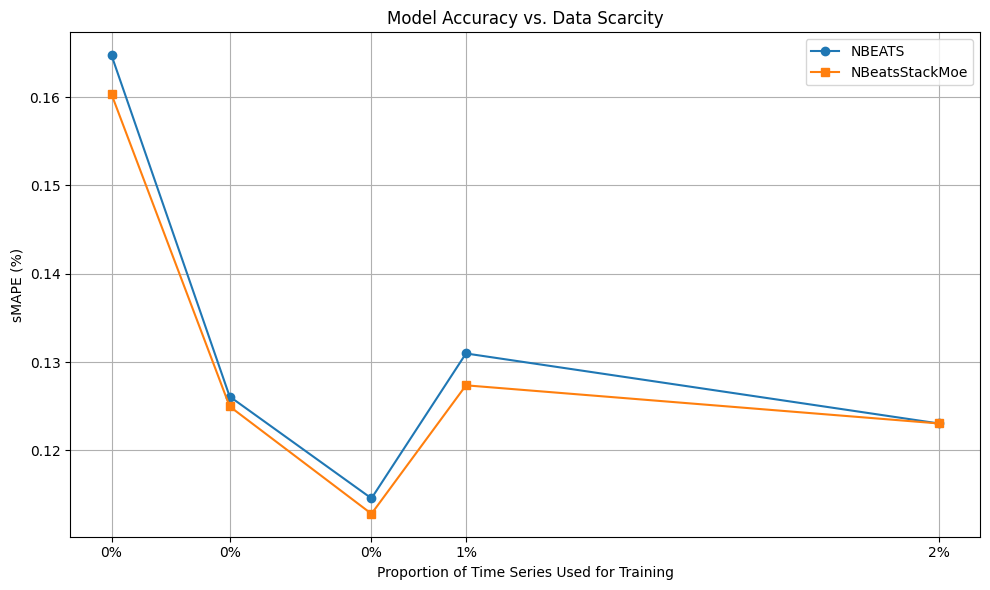

In [ ]:
import matplotlib.pyplot as plt

# Extract values
data_sizes = [r['data_size'] for r in results]
smape_nbeats = [r['sMAPE_NBEATS'] for r in results]
smape_moe = [r['sMAPE_MOE'] for r in results]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, smape_nbeats, marker='o', label='NBEATS')
plt.plot(data_sizes, smape_moe, marker='s', label='NBeatsStackMoe')

plt.xlabel('Proportion of Time Series Used for Training')
plt.ylabel('sMAPE (%)')
plt.title('Model Accuracy vs. Data Scarcity')
plt.grid(True)
plt.legend()
plt.xticks(data_sizes, [f"{int(s * 100)}%" for s in data_sizes])
plt.tight_layout()
plt.show()
